In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from models.factory import get_model
from src.dataset import TGADataset
from torch.utils.data import DataLoader

In [2]:
# Configuration
data_path = '../data/tga/data.npz'
model_name = 'even_smaller_variational_autoencoder' 
checkpoint_path = '/home/luiz/Documentos/ufmg/nanocomp/tga-feature-extraction/checkpoints/even_smaller_variational_autoencoder/cool_model_8_features_200/final.pth'
latent_dim = 8
num_interpolation_steps = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load Dataset
dataset = TGADataset(data_path=data_path, mode='reconstruction')
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Load Model
print(f"Loading model: {model_name}")
model = get_model(model_name, compressed_dim=latent_dim)
model.load_checkpoint(checkpoint_path, device)
model.to(device)
model.double()
model.eval()

print("Model loaded successfully")

Loading model: even_smaller_variational_autoencoder
Model loaded successfully
Model loaded successfully


In [4]:
# Get all data
all_data, _ = next(iter(dataloader))
all_data = all_data.to(device)

print(f"Dataset size: {all_data.shape}")

Dataset size: torch.Size([113, 2, 1024])


In [5]:
def interpolate_latent(model, x1, x2, num_steps=10):
    """
    Interpolate between two samples in latent space.
    
    Args:
        model: VAE model
        x1: First sample (1, 2, 1024)
        x2: Second sample (1, 2, 1024)
        num_steps: Number of interpolation steps
    
    Returns:
        interpolated_samples: Reconstructed samples along the interpolation (num_steps, 2, 1024)
        latent_codes: Latent codes along the interpolation (num_steps, latent_dim)
    """
    with torch.no_grad():
        # Encode both samples
        z1 = model.encode(x1)
        z2 = model.encode(x2)
        
        # Create interpolation weights (from 0 to 1)
        alphas = torch.linspace(0, 1, num_steps).to(device)
        
        # Interpolate in latent space: z_interp = (1-alpha)*z1 + alpha*z2
        interpolated_latents = []
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            interpolated_latents.append(z_interp)
        
        interpolated_latents = torch.cat(interpolated_latents, dim=0)
        
        # Decode interpolated latents
        # For VAE, we need to manually decode using the decoder
        d = model.decoder_input(interpolated_latents)
        
        # Reshape based on model architecture
        if model_name == 'bigger_variational_autoencoder':
            d = d.view(-1, 1024, 32)
        elif model_name == 'even_smaller_variational_autoencoder':
            d = d.view(-1, 4, 128)
            d = model.channel_expand(d)
        elif model_name in ['small_variational_autoencoder', 'micro_variational_autoencoder', 'nano_variational_autoencoder']:
            d = d.view(-1, 4, 128)
            d = model.channel_expand(d)
        else:  # variational_autoencoder
            d = d.view(-1, 64, 256)
        
        reconstructed = model.decoder_backbone(d)
        
    return reconstructed.cpu().numpy(), interpolated_latents.cpu().numpy()

In [6]:
# Select two random samples to interpolate between
idx1, idx2 = np.random.choice(len(all_data), 2, replace=False)

print(f"Interpolating between samples {idx1} and {idx2}")

x1 = all_data[idx1:idx1+1]
x2 = all_data[idx2:idx2+1]

# Perform interpolation
interpolated_samples, latent_codes = interpolate_latent(
    model, x1, x2, num_steps=num_interpolation_steps
)

print(f"Interpolated samples shape: {interpolated_samples.shape}")
print(f"Latent codes shape: {latent_codes.shape}")

Interpolating between samples 93 and 33
Interpolated samples shape: (10, 2, 1024)
Latent codes shape: (10, 8)


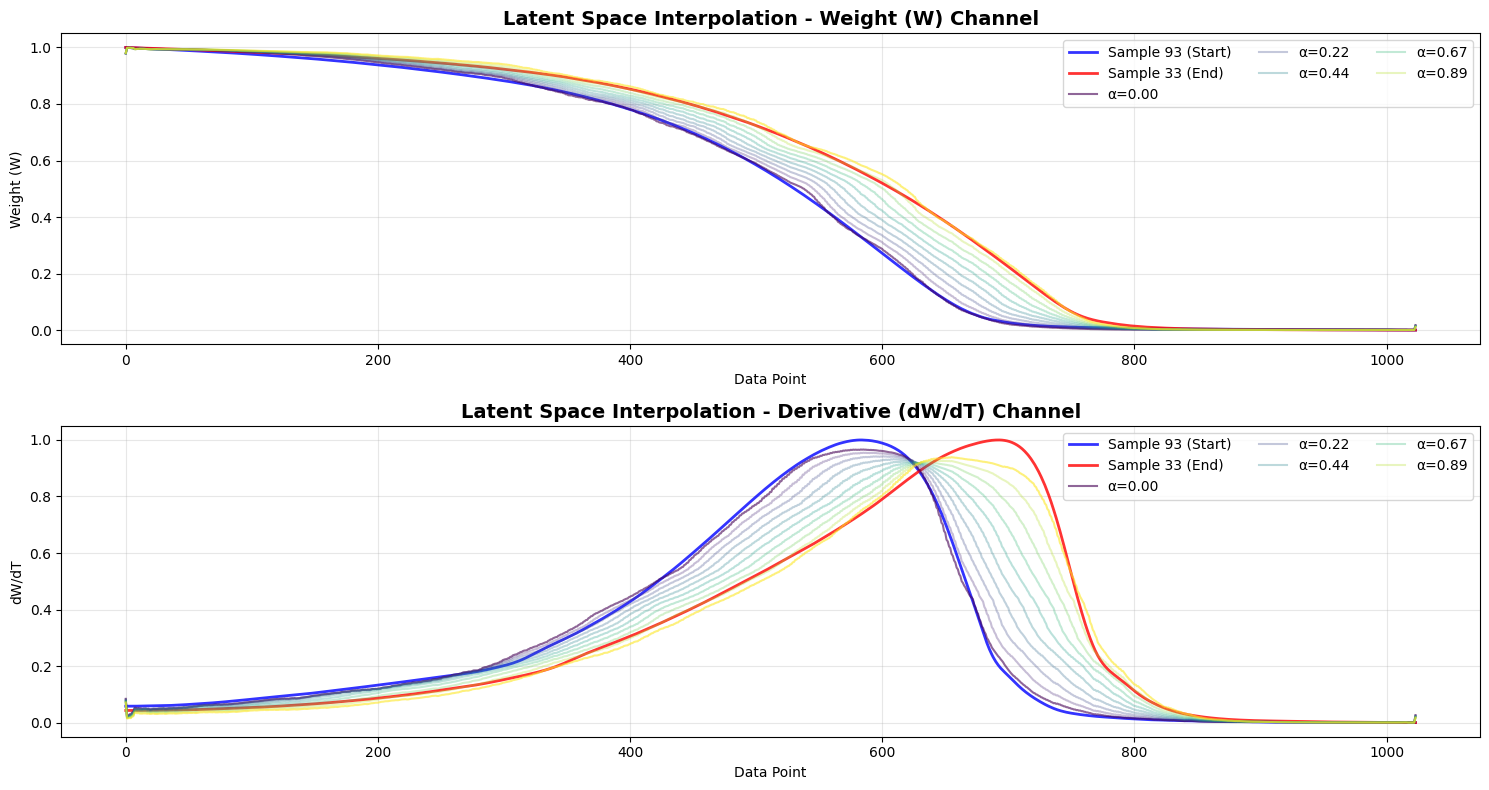

Figure saved to: figures/latent_interpolation.png


In [7]:
# Visualize interpolation for Weight channel
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Original samples
x1_np = x1.cpu().numpy()
x2_np = x2.cpu().numpy()

# Plot Weight (W) channel
axes[0].plot(x1_np[0, 0], 'b-', linewidth=2, label=f'Sample {idx1} (Start)', alpha=0.8)
axes[0].plot(x2_np[0, 0], 'r-', linewidth=2, label=f'Sample {idx2} (End)', alpha=0.8)

# Plot interpolated samples
cmap = plt.cm.viridis
for i in range(num_interpolation_steps):
    color = cmap(i / (num_interpolation_steps - 1))
    alpha_val = 0.3 if i not in [0, num_interpolation_steps-1] else 0.6
    axes[0].plot(interpolated_samples[i, 0], color=color, alpha=alpha_val, 
                linewidth=1.5, label=f'α={i/(num_interpolation_steps-1):.2f}' if i % 2 == 0 else '')

axes[0].set_title('Latent Space Interpolation - Weight (W) Channel', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Weight (W)')
axes[0].legend(loc='best', ncol=3)
axes[0].grid(True, alpha=0.3)

# Plot Derivative (dW/dT) channel
axes[1].plot(x1_np[0, 1], 'b-', linewidth=2, label=f'Sample {idx1} (Start)', alpha=0.8)
axes[1].plot(x2_np[0, 1], 'r-', linewidth=2, label=f'Sample {idx2} (End)', alpha=0.8)

for i in range(num_interpolation_steps):
    color = cmap(i / (num_interpolation_steps - 1))
    alpha_val = 0.3 if i not in [0, num_interpolation_steps-1] else 0.6
    axes[1].plot(interpolated_samples[i, 1], color=color, alpha=alpha_val,
                linewidth=1.5, label=f'α={i/(num_interpolation_steps-1):.2f}' if i % 2 == 0 else '')

axes[1].set_title('Latent Space Interpolation - Derivative (dW/dT) Channel', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('dW/dT')
axes[1].legend(loc='best', ncol=3)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/latent_interpolation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to: figures/latent_interpolation.png")

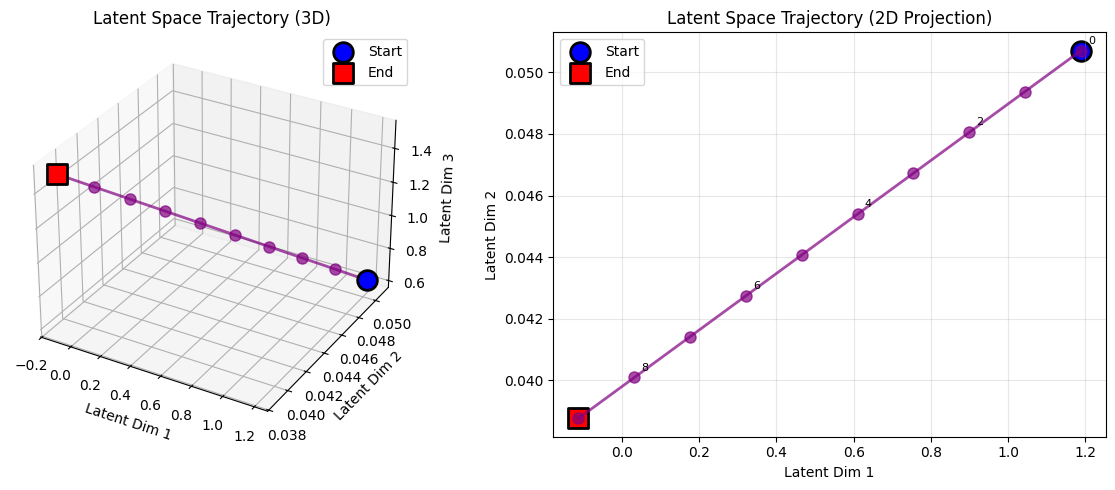

Latent trajectory figure saved to: figures/latent_trajectory.png


In [8]:
# Visualize latent space trajectory
if latent_dim >= 2:
    fig = plt.figure(figsize=(12, 5))
    
    if latent_dim >= 3:
        # 3D plot
        ax = fig.add_subplot(121, projection='3d')
        ax.plot(latent_codes[:, 0], latent_codes[:, 1], latent_codes[:, 2], 
               'o-', markersize=8, linewidth=2, color='purple', alpha=0.7)
        ax.scatter(latent_codes[0, 0], latent_codes[0, 1], latent_codes[0, 2],
                  s=200, c='blue', marker='o', label='Start', edgecolors='black', linewidth=2)
        ax.scatter(latent_codes[-1, 0], latent_codes[-1, 1], latent_codes[-1, 2],
                  s=200, c='red', marker='s', label='End', edgecolors='black', linewidth=2)
        ax.set_xlabel('Latent Dim 1')
        ax.set_ylabel('Latent Dim 2')
        ax.set_zlabel('Latent Dim 3')
        ax.set_title('Latent Space Trajectory (3D)')
        ax.legend()
        
        # 2D projection
        ax2 = fig.add_subplot(122)
    else:
        ax2 = fig.add_subplot(111)
    
    # 2D plot (first 2 dimensions)
    ax2.plot(latent_codes[:, 0], latent_codes[:, 1], 
            'o-', markersize=8, linewidth=2, color='purple', alpha=0.7)
    ax2.scatter(latent_codes[0, 0], latent_codes[0, 1],
               s=200, c='blue', marker='o', label='Start', edgecolors='black', linewidth=2)
    ax2.scatter(latent_codes[-1, 0], latent_codes[-1, 1],
               s=200, c='red', marker='s', label='End', edgecolors='black', linewidth=2)
    
    # Add step numbers
    for i in range(0, num_interpolation_steps, max(1, num_interpolation_steps // 5)):
        ax2.annotate(f'{i}', (latent_codes[i, 0], latent_codes[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Latent Dim 1')
    ax2.set_ylabel('Latent Dim 2')
    ax2.set_title('Latent Space Trajectory (2D Projection)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/latent_trajectory.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Latent trajectory figure saved to: figures/latent_trajectory.png")

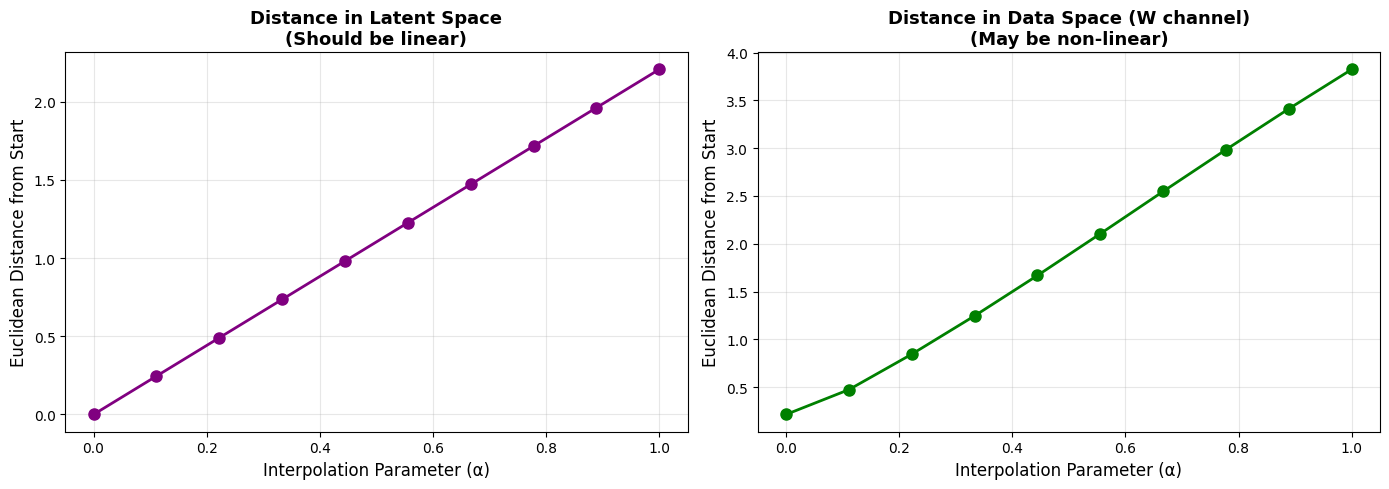


Distance Analysis:
Latent space is linear
Correlation between α and latent distance: 1.0000
Correlation between α and data distance: 0.9988


In [9]:
# Calculate distances to show smooth transition
from scipy.spatial.distance import euclidean

# Distance in latent space (should be linear)
latent_distances = []
for i in range(len(latent_codes)):
    dist = euclidean(latent_codes[0], latent_codes[i])
    latent_distances.append(dist)

# Distance in data space (W channel)
data_distances = []
for i in range(len(interpolated_samples)):
    dist = euclidean(x1_np[0, 0], interpolated_samples[i, 0])
    data_distances.append(dist)

# Plot distances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas = np.linspace(0, 1, num_interpolation_steps)

axes[0].plot(alphas, latent_distances, 'o-', linewidth=2, markersize=8, color='purple')
axes[0].set_xlabel('Interpolation Parameter (α)', fontsize=12)
axes[0].set_ylabel('Euclidean Distance from Start', fontsize=12)
axes[0].set_title('Distance in Latent Space\n(Should be linear)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(alphas, data_distances, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Interpolation Parameter (α)', fontsize=12)
axes[1].set_ylabel('Euclidean Distance from Start', fontsize=12)
axes[1].set_title('Distance in Data Space (W channel)\n(May be non-linear)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/interpolation_distances.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDistance Analysis:")
print(f"Latent space is {'linear' if np.corrcoef(alphas, latent_distances)[0, 1] > 0.99 else 'non-linear'}")
print(f"Correlation between α and latent distance: {np.corrcoef(alphas, latent_distances)[0, 1]:.4f}")
print(f"Correlation between α and data distance: {np.corrcoef(alphas, data_distances)[0, 1]:.4f}")

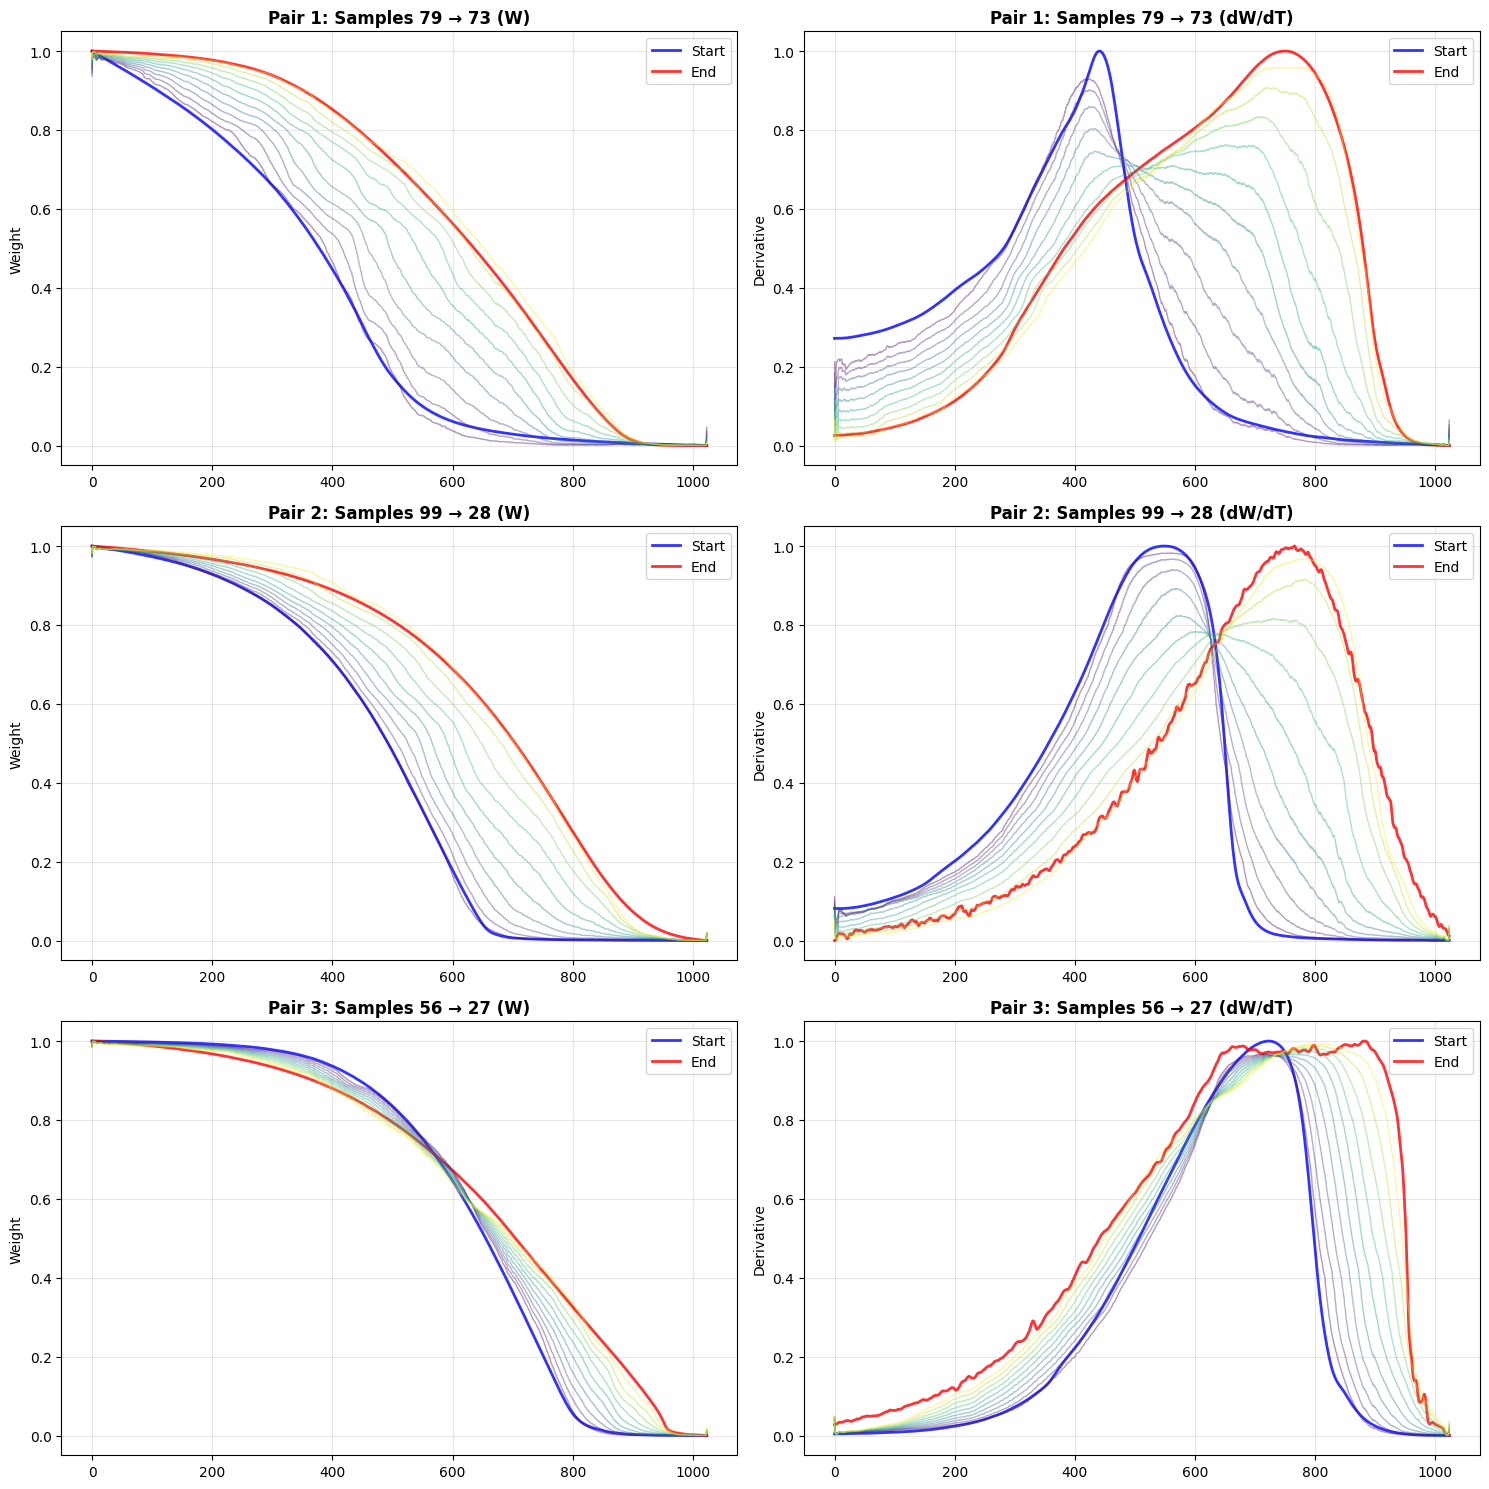

Tested 3 interpolation pairs


In [10]:
# Advanced: Compare multiple interpolation paths
def test_multiple_interpolations(model, data, num_pairs=3, num_steps=10):
    """
    Test interpolation for multiple random pairs of samples.
    """
    fig, axes = plt.subplots(num_pairs, 2, figsize=(15, 5*num_pairs))
    
    if num_pairs == 1:
        axes = axes.reshape(1, -1)
    
    for pair_idx in range(num_pairs):
        # Select random pair
        idx1, idx2 = np.random.choice(len(data), 2, replace=False)
        x1 = data[idx1:idx1+1]
        x2 = data[idx2:idx2+1]
        
        # Interpolate
        interpolated, latents = interpolate_latent(model, x1, x2, num_steps)
        
        x1_np = x1.cpu().numpy()
        x2_np = x2.cpu().numpy()
        
        # Plot W channel
        axes[pair_idx, 0].plot(x1_np[0, 0], 'b-', linewidth=2, label='Start', alpha=0.8)
        axes[pair_idx, 0].plot(x2_np[0, 0], 'r-', linewidth=2, label='End', alpha=0.8)
        
        cmap = plt.cm.viridis
        for i in range(num_steps):
            color = cmap(i / (num_steps - 1))
            axes[pair_idx, 0].plot(interpolated[i, 0], color=color, alpha=0.4, linewidth=1)
        
        axes[pair_idx, 0].set_title(f'Pair {pair_idx+1}: Samples {idx1} → {idx2} (W)', fontweight='bold')
        axes[pair_idx, 0].set_ylabel('Weight')
        axes[pair_idx, 0].legend()
        axes[pair_idx, 0].grid(True, alpha=0.3)
        
        # Plot dW/dT channel
        axes[pair_idx, 1].plot(x1_np[0, 1], 'b-', linewidth=2, label='Start', alpha=0.8)
        axes[pair_idx, 1].plot(x2_np[0, 1], 'r-', linewidth=2, label='End', alpha=0.8)
        
        for i in range(num_steps):
            color = cmap(i / (num_steps - 1))
            axes[pair_idx, 1].plot(interpolated[i, 1], color=color, alpha=0.4, linewidth=1)
        
        axes[pair_idx, 1].set_title(f'Pair {pair_idx+1}: Samples {idx1} → {idx2} (dW/dT)', fontweight='bold')
        axes[pair_idx, 1].set_ylabel('Derivative')
        axes[pair_idx, 1].legend()
        axes[pair_idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/multiple_interpolations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Tested {num_pairs} interpolation pairs")

# Run multiple interpolations
test_multiple_interpolations(model, all_data, num_pairs=3, num_steps=num_interpolation_steps)